# Instructions for running code:
Install roboschool, openAI gym

In [1]:
###### Libraries and packages to import
import roboschool
import gym
import numpy as np
import math
from scipy import linalg
from numpy.linalg import matrix_rank
import time

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 
import pickle

from scipy import linalg

In [2]:
class Reacher:
    
    #this function sets up the environment and instantiates a reacher with a random state
    def setup_environment(self):
        self.a = np.array([0.,0.])
        # setting up the environment
        self.env = gym.make('RoboschoolReacher-v1')
        self.env.seed(10)
        self.state = self.env.reset()


        #the loop will keep on running the reset function till it gets a reachable state
        while (self.if_target_reachable(self.state[0], self.state[1]) == False):
            self.state = self.env.reset()

        th1 = np.arctan2(self.state[5],self.state[4])
        th2= (self.state[7]*3.14)

        th1 = (((th1+np.pi) % (2*np.pi)) - np.pi)
        th2 = (((th2+np.pi) % (2*np.pi)) - np.pi)
        
        th1_dot = self.state[6]
        th2_dot = self.state[8]
    #     print("target reachable")
        
        while ((-0.001 > th1 or th1 > 0.001) or (-0.001 > th2 or th2 > 0.001)):
#             print("not yet")
#             print(th1)
#             print(th2)
            self.a[0] = 0.5*(0. - th1) - 2*(th1_dot - 0)
            self.a[1] = 0.5*(0. - th2) - 2*(th2_dot - 0)
            
            self.state, b, c, d = self.env.step(self.a)
#             self.env.render() 
            th1 = np.arctan2(self.state[5],self.state[4])
            th2= (self.state[7]*3.14)

            th1 = (((th1+np.pi) % (2*np.pi)) - np.pi)
            th2 = (((th2+np.pi) % (2*np.pi)) - np.pi)

            th1_dot = self.state[6]
            th2_dot = self.state[8]
            
            

        return self.state, self.a, self.env
    
    #this function checks whether the goal is reachable
    def if_target_reachable(self,target_x, target_y):
        target = np.sqrt(target_x**2 + target_y**2)
        link_1 = 0.1
        link_2 = 0.11

        if target < np.sqrt(link_1**2 + link_2**2):
            return True

        else:
    #         print('target unreachable')
            return False
    
    #this function derives the inverse kinematics of the target x and y, giving joint theta values
    def inverse_kinematics(self, target_x, target_y):
        link_1 = 0.1
        link_2 = 0.11
        q2 =np.arccos((target_x**2 + target_y**2 - link_1**2 - link_2**2)/(2*link_1*link_2))
        q1 = np.arctan2(target_y,target_x)-np.arctan2((link_2*np.sin(q2)),(link_1+link_2*np.cos(q2)))
        return q1,q2 

In [3]:
class PathIntegral:
    
    def __init__(self, model):
        
        #here N is the number of disretized trajectory points
        self.N = 4
        #here K is the number of trajectories
        self.K = 10
        #J is the number of joints
        self.J = 3
        
        #No of parameter updates
        self.iters = 1
        self.sim_t = 800
        
        #setup environment & it checks if the target is reachable for the manipulator or not
        self.model = model
        self.state,self.a,self.env = self.model.setup_environment()
        #inverse kinematics of the target position, to get the desired state space of the reacher
        self.th1_target, self.th2_target = self.model.inverse_kinematics(self.state[0], self.state[1])
        
        #wrapping angles form 0 to 2 pi
        self.th1_target = (((self.th1_target+np.pi) % (2*np.pi)) - np.pi)
        self.th2_target = (((self.th2_target+np.pi) % (2*np.pi)) - np.pi)
        
        #assigning start state
        self.th1_start = np.arctan2(self.state[5],self.state[4])
        self.th2_start= (self.state[7]*3.14)
        self.th1_start = (((self.th1_start+np.pi) % (2*np.pi)) - np.pi)
        self.th2_start = (((self.th2_start+np.pi) % (2*np.pi)) - np.pi)
        
        #setting target velocities
        self.th1_dot_target = 0.
        self.th2_dot_target = 0.
        
        #creating an initial trajectory between start and goal state
        self.th1_traj = np.linspace(0.0, 1.57, self.N)
        self.th2_traj = np.linspace(0.0, 0.0, self.N)
        self.th1_traj = self.th1_traj +0.1*np.random.random(size = self.N)
        self.th2_traj = self.th1_traj +0.1*np.random.random(size = self.N)
        self.th1_traj_arr = np.zeros([self.K,self.N])
        self.th2_traj_arr = np.zeros([self.K,self.N])
        self.noise0 = np.zeros([self.K,self.N])
        self.noise1= np.zeros([self.K,self.N])
        self.state_cost_all = np.zeros([self.J,self.K,self.N])
        self.control_cost_all = np.zeros([self.J,self.K,self.N])
        self.state_cost_total = np.zeros([self.J,self.K,self.N])
        self.control_cost_total = np.zeros([self.J,self.K,self.N])
        self.cost = np.zeros([self.J,self.K, self.N])
        
        #R is the square of finite difference matrix for acceleration A2^2
        self.R = self.get_R()
        self.R_inv = linalg.inv(self.R)
        #M_arr is a list of M matrices for each time step
        self.M_arr = self.get_M()
        #delta_theta stores theta updates for each of the joint angles
        self.noise_less_cost = np.zeros([self.iters,1])
        self.terminal_cost = np.zeros([self.J,1])
        
        self.make_trajectories() 
        mean = np.zeros([self.N])
        self.th1_traj = self.th1_traj +0*np.random.multivariate_normal(mean,self.R_inv)
        self.th2_traj = self.th2_traj +0*np.random.multivariate_normal(mean,self.R_inv)
        self.th1_traj = (((self.th1_traj+np.pi) % (2*np.pi)) - np.pi)
        self.th2_traj = (((self.th2_traj+np.pi) % (2*np.pi)) - np.pi)
        
        self.state_cost_plot = np.zeros([self.iters,1])
        self.control_cost_plot = np.zeros([self.iters,1])
        self.terminal_cost_plot = np.zeros([self.iters,1])
        self.plot_x = np.zeros([self.sim_t,1])
        self.plot_y = np.zeros([self.sim_t,1])
        self.plot_control_cost_inst = np.zeros([self.sim_t,2])
        self.terminal_cost_total = np.zeros([2,self.sim_t])
        self.terminal_cost_cum = 0.
        self.way_point_cost = np.zeros([self.K,self.N])
        
    #this function creates R matrix
    def get_R(self):
# #     first order finite differences
#         A1 = np.zeros([self.N+1,self.N])
#         for i in range (self.N+1):
#             for j in range(self.N):
#                 if(i==j):
#                     A1[i,j] = 1
#                     if(i>0 & i<self.N-1):
#                         A1[i,j-1] =-1
#         A1[self.N,self.N-1] = 1
#         return A1.T@A1
    
#     second order finite differences
        A2 = np.zeros([self.N+2,self.N])
        for i in range (self.N+2):
            for j in range(self.N):
                if(i==j):
                    A2[i,j] = 1
                    if(i>0 & i<self.N+1):
                        A2[i,j-1] =-2
                        if(i>1 & i<self.N+1):
                            A2[i,j-2] =1
        A2[self.N,self.N-2] = 1
        A2[self.N,self.N-1] = -2
        A2[self.N+1,self.N-1] = 1
        wd = 1.
        print(A2)
        return wd*A2.T@A2
    
    #creates an array of M matrices for each time step
    def get_M(self):
        M_arr = [] 
        for i in range(self.N):
            gt = np.zeros([self.N, 1])
            gt[i,0] = 1.
            M = (self.R_inv@gt@gt.T)/(gt.T@(self.R_inv)@gt)
#             M = (self.R_inv@gt@gt.T)/(gt.T@(self.R_inv)@gt)
            M_arr.append(M)
#             print(gt,"gt")
#             print(gt.T,"gt.T")
#             print(M,"M")
#             print(self.R_inv,"R_inv")
        return M_arr


    #makes K trajectories with noise from start to goal position
    def make_trajectories(self):
        noise_scale = 0.01
        mean = np.zeros([self.N])
#         print(mean)
        for k in range(self.K):
            #multivariate noise with zero mean and R_inv variance
            self.noise0[k,:] = noise_scale*np.random.multivariate_normal(mean,self.R_inv).T
            self.noise1[k,:] = noise_scale*np.random.multivariate_normal(mean,self.R_inv).T
            self.noise0[k,0] = 0.
            self.noise1[k,0] = 0.
            self.noise0[k,-1] = 0.
            self.noise1[k,-1] = 0.
            self.th1_traj_arr[k] = self.th1_traj + self.noise0[k]
            self.th2_traj_arr[k] = self.th2_traj + self.noise1[k]
            self.th1_traj_arr[k] = (((self.th1_traj_arr[k]+np.pi) % (2*np.pi)) - np.pi)
            self.th2_traj_arr[k] = (((self.th2_traj_arr[k]+np.pi) % (2*np.pi)) - np.pi)
#         print(self.noise)
#             print(self.th1_traj_arr[k])
#             print(self.th2_traj_arr[k])
        
#         plt.plot(range(self.N), noise_scale*self.noise0.T)
#         plt.plot(range(self.N), self.th1_traj_arr[0].T)
# #         plt.plot(range(self.N), self.R_inv)
#         plt.xlabel("time")
#         plt.ylabel("theta")
#         plt.show() 
    
    def traj_probability(self, L=100):
        Pr = np.zeros([self.J,self.K,self.N])
        P = np.zeros([self.J,self.K,self.N])
        Pr_sum = np.zeros([self.J,self.N])
        num1 = -10*(self.cost[0,:,:]-np.amin(self.cost[0,:,:],axis = 0))
        denom1 = (np.amax(self.cost[0,:,:],axis = 0)-np.amin(self.cost[0,:,:],axis = 0))
        num2 = -10*(self.cost[1,:,:]-np.amin(self.cost[1,:,:],axis = 0))
        denom2 = (np.amax(self.cost[1,:,:],axis = 0)-np.amin(self.cost[1,:,:],axis = 0))
        if(denom1[-1] < 10e-6):
            denom1[-1] = 10e-6
        if(denom2[-1] < 10e-6):
            denom2[-1] = 10e-6
        Pr[0,:,:] = np.exp(num1 / denom1)
        Pr[1,:,:] = np.exp(num2 / denom2)
#         print(Pr[0,:,-1],"P")
        for t in range(self.N): 
#             print(Pr)
            Pr_sum[0,t] = 0.
            for k in range (self.K):
                Pr_sum[0,t] += Pr[0,k,t] 
#                 print(Pr_sum[0,t])
#                 print(Pr[0,k,t])
                Pr_sum[1,t] += Pr[1,k,t] 
#                 print(self.cost[0,k,t],"cost",k, "t",t)
            P[0,:,t] = Pr[0,:,t]/Pr_sum[0,t]
            P[1,:,t] = Pr[1,:,t]/Pr_sum[1,t]
            
        
        return P
    
    def del_theta(self,P, M,t):
        delta_theta = np.zeros([self.J,self.N])
        for k in range(self.K):
            
            delta_theta[0,:] += P[0,k,t]*(M@self.noise0[k].T)
            delta_theta[1,:] += P[1,k,t]*(M@self.noise1[k].T)
#             print(P[0,k,t],"delta_theta")
#             print(k,"k")
#             print(delta_theta.shape,"delta_theta shape")
        return delta_theta
    
    def update_parameters(self,delta_theta_arr):
        delta_param = np.zeros([self.J, self.N])
        for t in range(self.N):
            delta_param[0,t] = np.mean(delta_theta_arr[0,t,:])
            delta_param[1,t] = np.mean(delta_theta_arr[1,t,:])
#         print(delta_theta_arr[0,t,-1],"param")
        self.th1_traj += delta_param[0,:].T
        self.th2_traj += delta_param[1,:].T
        self.th1_traj = (((self.th1_traj+np.pi) % (2*np.pi)) - np.pi)
        self.th2_traj = (((self.th2_traj+np.pi) % (2*np.pi)) - np.pi)
        self.make_trajectories()
        
    
    def cost_inst(self,k,t, th1, th2, th1_dot, th2_dot,i, noise_added = True):
        
        if (t == 3*self.N/4):
            
            self.way_point_cost[k,t] = 1000000*(self.state[2]**2 + self.state[3]**2)
        else:
            self.way_point_cost[k,t] = 0.
        
#              
        if (noise_added):
            self.state_cost_all[0,k,t] = 1000.*( th1_dot**2 +(th1-self.th1_traj_arr[k,t])**2)
#             print(self.state_cost_all[0,k,t])
            self.state_cost_all[1,k,t] = 1000.*(th2_dot**2 + (th2-self.th2_traj_arr[k,t])**2)
            self.control_cost_all[0,k,t] = 1*((self.th1_traj+self.M_arr[t]@self.noise0[k].T)@self.R@(self.th1_traj+self.M_arr[t]@self.noise0[k].T).T)
            self.control_cost_all[1,k,t] = 1*((self.th2_traj+self.M_arr[t]@self.noise1[k].T)@self.R@(self.th2_traj+self.M_arr[t]@self.noise1[k].T).T)
            self.plot_control_cost_inst[i,0] = self.control_cost_all[0,k,t]
            self.plot_control_cost_inst[i,1] = self.control_cost_all[1,k,t]
            
        else:
            self.state_cost_all[0,0,t] = 10.*(th1_dot**2 + (th1-self.th1_traj[t])**2 )
            self.state_cost_all[1,0,t] = 10.*(th2_dot**2 + (th2-self.th2_traj[t])**2 )
            self.control_cost_all[0,0,t] = 1*((self.th1_traj)@self.R@(self.th1_traj).T )
            self.control_cost_all[1,0,t] = 1*((self.th2_traj)@self.R@(self.th2_traj).T )
        
        
    def cost_terminal(self,th1,th2,th1_dot,th2_dot,i):
        self.terminal_cost[0] = 10000*((th1_dot - 0)**2 + 10*(1.57 - th1)**2)
#         print(self.terminal_cost[0])
        self.terminal_cost[1] = 10000*((th2_dot - 0)**2 + 10*(0 - th2)**2)
        self.terminal_cost_total[0,i] = self.terminal_cost[0]
        self.terminal_cost_total[1,i] = self.terminal_cost[1]
        self.terminal_cost_cum += self.terminal_cost_total[0,i] + self.terminal_cost_total[1,i]  
    def get_cost(self, itr, noise_added=True ):
        temp_state_cost = np.zeros([self.J,1])
        temp_control_cost = np.zeros([self.J,1])
        if(noise_added):
            
            for k in range(self.K):

                for t in range(self.N):

                    temp_state_cost[:] = 0.
#                     print(temp_state_cost[:],"tempstatecost")
                    temp_control_cost[:] = 0.

                    for i in range(t,self.N):
                        temp_state_cost[:,0] += self.state_cost_all[:,k,i] 
                        temp_control_cost[:,0] += self.control_cost_all[:,k,i] 
                    self.state_cost_total[:,k,t] = temp_state_cost[:,0]
                    self.control_cost_total[:,k,t] = temp_control_cost[:,0]
#                     print(self.state_cost_all.size)
            self.cost[0] =   self.state_cost_total[0,:,:] + 0.5*self.control_cost_total[0,:,:] + self.terminal_cost[0]
#             
            self.cost[1] =   self.state_cost_total[1,:,:] + 0.5*self.control_cost_total[1,:,:] +self.terminal_cost[1]
#             
            return self.cost #self.terminal_cost[:,0]
            
        else:
            
#             print(self.noise_less_cost[itr])
            for t in range (self.N):
                self.noise_less_cost[itr] += self.state_cost_all[0,0,t] + self.state_cost_all[1,0,t] \
                + 0.5*self.control_cost_all[0,0,t] + 0.5*self.control_cost_all[1,0,t]  + self.terminal_cost[0] +self.terminal_cost[1]
#                 print(self.state_cost_all[0,0,t],itr)
                
#             self.noise_less_cost[itr] += self.terminal_cost[0] + self.terminal_cost[1]
                self.state_cost_plot[itr] += self.state_cost_all[0,0,t]
                self.control_cost_plot[itr] += self.control_cost_all[0,0,t]
                self.terminal_cost_plot[itr] += self.terminal_cost[0]
            
        
    
    def rollout(self, itr,k, noise_added=True):
        
        t = 0
        
        for i in range(self.sim_t):
            t = int(np.clip(t, 0, self.N-1))
            
            #Reading current states
            th1 = np.arctan2(self.state[5],self.state[4])
            th2= (self.state[7]*3.14)

            th1 = (((th1+np.pi) % (2*np.pi)) - np.pi)
            th2 = (((th2+np.pi) % (2*np.pi)) - np.pi)

            th1_dot = self.state[6]
            th2_dot = self.state[8]
#             print(t,"t")
            if(t<self.N-1):
                

                if(noise_added):
                    #Torque to be applied
                    self.a[0] = 2.5*(self.th1_traj_arr[k,t+1] - th1) - 2*(th1_dot - 0)
                    
                    self.a[1] = 2.5*(self.th2_traj_arr[k,t+1] - th2) - 2*(th2_dot - 0)
                    #compute instaneous cost
                    self.cost_inst(k, t, th1, th2, th1_dot, th2_dot,i)

                #rollout a noise_free trajectory
                else:
                    #Torque to be applied
                    self.a[0] = 2.5*(self.th1_traj[t+1] - th1) - 2*(th1_dot - 0)
                    self.a[1] = 2.5*(self.th2_traj[t+1] - th2) - 2*(th2_dot - 0)
                    #compute instaneous cost
                    self.cost_inst(k, t, th1, th2, th1_dot, th2_dot,i,False)

            if(t == self.N-1):
                #compute terminal cost
                self.cost_terminal(th1,th2,th1_dot,th2_dot,i)
                self.a[0] = 2.5*(1.57 - th1) - 2*(th1_dot - 0)
                self.a[1] = 2.5*(0 - th2) - 2*(th2_dot - 0)
            
#             take a step in the environment    
            self.plot_control_cost_inst[i,0] = self.a[0]
            self.plot_control_cost_inst[i,1] = self.a[1]
        
            self.state, b, c, d = self.env.step(self.a)
            
#             if (itr ==0):
#                 self.env.render()
        
#                 print(self.a)
#                 print(t,"t")
            if(i%40 == 0):
                t = t+1
            
            if(itr == 0 and i == self.sim_t-1 ):
                print(self.th1_traj)
                
            if(itr == 49 and i == self.sim_t-1 ):
                print(self.th1_traj)
                
            if(itr == 49 and i %40 ==0):
                print(th1,"th1")
                print(i,"i")
            
            self.plot_x[i] = self.state[2]
            self.plot_y[i] = self.state[3]
            
    def iteration(self,itr):
        P = np.zeros([self.J,self.K,self.N])
        for k in range(self.K):
            self.state, self.a, self.env = self.model.setup_environment()
            
            self.rollout(itr,k, True)
            
        cost = self.get_cost(itr)
       
        P = self.traj_probability()
#         print(itr)
        #rollout a noise-less trajectory
        self.state, self.a, self.env = self.model.setup_environment()
        
        self.state_cost_total[:] = 0.
        self.control_cost_total[:] = 0.
        self.terminal_cost[:] = 0.
        self.cost[:] = 0.
        self.rollout(itr,k, False)
        self.get_cost(itr, False)
        
        delta_theta_arr = np.zeros([self.J,self.N,self.N])    
        
        for t in range(self.N):
            
            delta_theta_arr[:,:,t] = self.del_theta(P, self.M_arr[t],t)

        self.update_parameters(delta_theta_arr) 


[[ 1.  0.  0.  0.]
 [-2.  1.  0.  0.]
 [ 1. -2.  1.  0.]
 [ 0.  1. -2.  1.]
 [ 0.  0.  1. -2.]
 [ 0.  0.  0.  1.]]
[0.00393497 0.53897356 1.08127305 1.60295731]
[0.00393497 0.53897356 1.08127305 1.60295731]
[0.00393497 0.53897356 1.08127305 1.60295731]
[0.00393497 0.53897356 1.08127305 1.60295731]
[0.00393497 0.53897356 1.08127305 1.60295731]
[0.00393497 0.53897356 1.08127305 1.60295731]
[0.00393497 0.53897356 1.08127305 1.60295731]
[0.00393497 0.53897356 1.08127305 1.60295731]
[0.00393497 0.53897356 1.08127305 1.60295731]
[0.00393497 0.53897356 1.08127305 1.60295731]
[0.00393497 0.53897356 1.08127305 1.60295731]


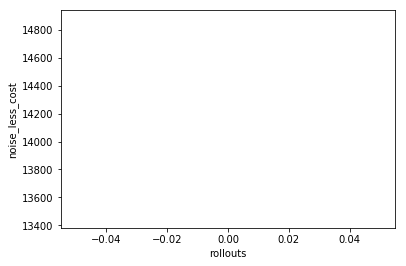

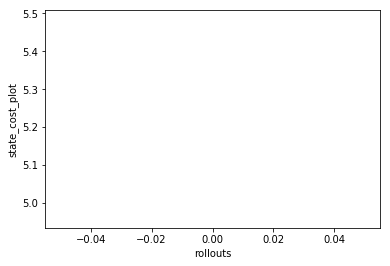

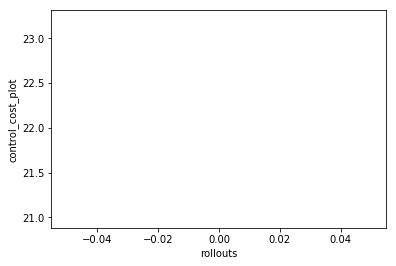

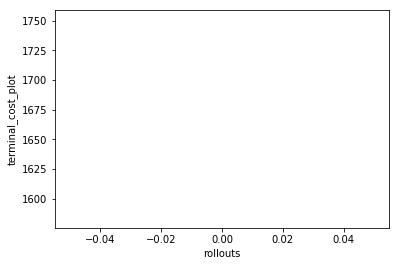

In [4]:
model = Reacher()
PI = PathIntegral(model)
waypoint = np.zeros([PI.iters*PI.K,PI.N])
cost = np.zeros([PI.iters,1])
for itr in range(PI.iters):
    waypoint[itr*PI.K:itr*PI.K+PI.K,:] = PI.way_point_cost[:,:]
    PI.iteration(itr)
#     print(itr)  
plt.plot(range(len(PI.noise_less_cost)), PI.noise_less_cost)
# plt.plot(range(N), R_inv)
plt.xlabel("rollouts")
plt.ylabel("noise_less_cost")
plt.show()

plt.plot(range(len(PI.state_cost_plot)), PI.state_cost_plot)
# plt.plot(range(N), R_inv)
plt.xlabel("rollouts")
plt.ylabel("state_cost_plot")
plt.show()

plt.plot(range(len(PI.control_cost_plot)), PI.control_cost_plot)
# plt.plot(range(N), R_inv)
plt.xlabel("rollouts")
plt.ylabel("control_cost_plot")
plt.show()


plt.plot(range(len(PI.terminal_cost_plot)), PI.terminal_cost_plot)
# plt.plot(range(N), R_inv)
plt.xlabel("rollouts")
plt.ylabel("terminal_cost_plot")
plt.show()


# plt.plot(range(N), noise.T)
#     #     plt.plot(range(N), R_inv)
# plt.xlabel("time")
#         plt.ylabel("theta")
#         plt.show()
    


In [5]:
max(PI.terminal_cost_plot)

array([1667.14373921])

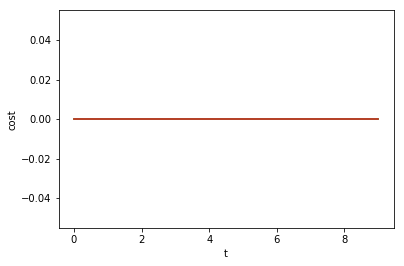

In [6]:
plt.plot(range(len(waypoint[:,0])), waypoint[:,:])
# plt.plot(range(N), R_inv)
plt.xlabel("t")
plt.ylabel("cost")
plt.show()